In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os               # for reading directories
import gc               # for garbage collector

import scipy.stats      # for Spearman correlation
import seaborn as sns   # for plotting heatmaps

from wordcloud import WordCloud         # for plotting wordcloud
import json             # for plotting wordcloud
from PIL import Image   # for plotting wordcloud

In [2]:
###### constants

# minimum value of weight parameter on topic for deciding that a paper concerns the topic
minimum_topic_weight = 0.2
# time window of the model
T_0 = [2000, 2004]
training_starting_year = T_0[0]
# the starting year for studying the topic diffusion: it must be in the range (training_starting_year, training_ending_year)
diffusion_starting_year      = 2005
# the ending year for studying the topic diffusion: it must be in the range [diffusion_starting_year, training_ending_year)
diffusion_ending_year        = 2014

# directory containing data files
MAIN_DIR = "./"
DATA_DIR = MAIN_DIR+"data"
topics_dir = DATA_DIR+"/topics"
diffusion_dir = DATA_DIR+"/diffusion"
innovation_dir = DATA_DIR+"/innovation"
images_dir = MAIN_DIR+"/images"

# number of topics in the model
number_of_topics = 50

# max value of delta
max_delta = 6

# file containing topics assignments
topics_assignments_filename = topics_dir+"/topics-assignments-2000-2004-153-"+str(number_of_topics)+"-2000-2014.csv"

# file containing mapping paper-author
papers_authors_filename = topics_dir+"/papers-authors-2000-2004-153-"+str(number_of_topics)+"-2000-2014.csv"

# file containing topic assignments
topics_assignment_filename = topics_dir+"/labeling-2000-2004-153-"+str(number_of_topics)+".json"

# file containing topic labels (written by human user)
topics_label_filename = topics_dir+"/mapping_name_topic_id_2000-2004-"+str(number_of_topics)+".csv"

# columns used for calculating the ranking
column_innovation = "new_authors_cumulative"
column_diffusion = "new_authors_cumulative"
column_innovation_rank = column_innovation+"-a"
column_diffusion_rank = column_diffusion+"-a"

###### create directories

#create directory
def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

makedir(DATA_DIR)
makedir(images_dir)
makedir(diffusion_dir)
makedir(innovation_dir)

## Statistics on dataset

In [3]:
#### Statistics on papers

#get dataframe of items <paper_id, year, topic_id, topic_weight>
def get_papers(topic_id_filename, year_from, year_to):
    # get topics for each paper
    paper_topics = pd.read_csv(topic_id_filename)
    if year_to > max(paper_topics['year']):
        raise ValueError("year_t must be lower or equal ", year_to)
    if year_from < min(paper_topics['year']):
        raise ValueError("year_t must be greater or equal ", year_from)
    return paper_topics[paper_topics["year"].between(year_from, year_to, inclusive=True)]

#plot dataframe of items <paper_id, year, topic_id>
def plot_papers_overview(csv, index, columns, cmap=plt.cm.Vega20, plot_count=False, filename=""):
    t = csv[csv["topic_weight"] >= minimum_topic_weight].pivot_table(index=index, columns=columns, values='acm_id', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    if plot_count:
        t = csv[csv["topic_weight"] >= minimum_topic_weight].groupby(["acm_id", index]).count().reset_index().groupby([index]).count().reset_index().sort_values(by=index, ascending=True)#.plot(x=index, y="acm_id", color="grey", ax=ax, label="_none")
        line = ax.plot(range(len(t[index])), t["acm_id"], 'o-', color="grey", label="none")
        plt.legend(handles=[line], loc=4)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("papers")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    return

#plot dataframe of items <paper_id, year, topic_id>
def plot_papers_overview(csv, index, columns, cmap=plt.cm.Vega20, plot_count=False, filename=""):
    t = csv[csv["topic_weight"] >= minimum_topic_weight].pivot_table(index=index, columns=columns, values='acm_id', aggfunc='count')
    fig = plt.figure(figsize=(12,5))
    ax  = fig.add_subplot(111)
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    l1 = ax.legend(bbox_to_anchor=(0.005, 0.895, 0.99, .10), loc=2, ncol=10, mode="expand", borderaxespad=0.)
    #set space for legend
    number_of_rows_legend = len(set(csv[csv["topic_weight"] >= minimum_topic_weight][columns]))
    number_of_rows_legend = int(number_of_rows_legend/10) if number_of_rows_legend%10 == 0 else 1 + int(number_of_rows_legend/10)
    ax.set_ylim(0, ax.get_ylim()[1]+(ax.get_ylim()[1]/9*number_of_rows_legend))
    #plot count
    if plot_count:
        t = csv[csv["topic_weight"] >= minimum_topic_weight].groupby(["acm_id", index]).count().reset_index().groupby([index]).count().reset_index().sort_values(by=index, ascending=True)#.plot(x=index, y="acm_id", color="grey", ax=ax, label="_none")
        line, = ax.plot(range(len(t[index])), t["acm_id"], 'o-', color="grey", label="papers")
        l2 = plt.legend(handles=[line], loc=4)
        ax.add_artist(l1)
        ax.add_artist(l2)
    plt.ylabel("papers")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', bbox_inches='tight', dpi=1000)
    plt.show()
    return

# plot number of papers by topic and by year
def plot_statistics_on_papers(topics_assignments_filename, year_from, year_to, show_all_topics=True, output_dir=""):
    #get dataframe of items <paper_id, year, topic_id, topic_weight>
    papers_csv = get_papers(topics_assignments_filename, year_from, year_to)
    
    print(papers_csv["acm_id"].nunique(), "papers")
    
    filename = ""
    if not(show_all_topics):
        topics_df = pd.read_csv(topics_label_filename)
    print("Number of paper concerning a topic by year")
    if output_dir != "":
        filename = output_dir+"/papers_in_topic"
    if show_all_topics:
        plot_papers_overview(papers_csv, 'topic_id', 'year', filename=filename)
    else:
        plot_papers_overview(papers_csv.merge(topics_df), 'label', 'year', filename=filename)

    print("Number of topics concerned in papers published in each year")
    if output_dir != "":
        filename = output_dir+"/papers_in_year"
    if show_all_topics:
        plot_papers_overview(papers_csv, 'year', 'topic_id', cmap=plt.cm.gist_rainbow, plot_count=True, filename=filename)
    else:
        plot_papers_overview(papers_csv.merge(topics_df), 'year', 'label', plot_count=True, filename=filename)
    return

#### Statistics on authors

#plot dataframe of items <paper_id, author_name, year, topic_id> letting the authors to repeat in the count
def plot_authors_overview(authors_csv, index, column, cmap=plt.cm.Vega20, filename=""):
    t = authors_csv[authors_csv["topic_weight"] >= minimum_topic_weight].pivot_table(index=index, columns=column, values='acm_id', aggfunc='count')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("authors")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.gcf().clear()
    return

#plot dataframe of items <paper_id, author_name, year, topic_id> where the authors are not repeated in the count
def plot_authors_norep_overview(authors_csv, index, column, cmap=plt.cm.Vega20, filename=""):
    t = authors_csv[authors_csv["topic_weight"] >= minimum_topic_weight].groupby([index, column,"author"]).count().reset_index().groupby([index, column]).count().reset_index().pivot_table(index=index, columns=column, values='acm_id', aggfunc='sum')
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    t.plot.bar(rot=0, stacked=True, ax=ax, cmap=cmap)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=10, mode="expand", borderaxespad=0.)
    plt.ylabel("authors")
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.gcf().clear()
    return

# plot number of authors by topic and by year
def plot_statistics_on_authors(topics_assignments_filename, year_from, year_to, show_all_topics=True, show_repetitions = False, output_dir=""):
    #get dataframe of items <paper_id, author_name, year, topic_id, topic_weight>
    authors_csv = get_papers(topics_assignments_filename, year_from, year_to).merge(pd.read_csv(papers_authors_filename))

    print(authors_csv["author"].nunique(), "authors")

    filename = ""
    if not(show_all_topics):
        topics_df = pd.read_csv(topics_label_filename)

    if show_repetitions:
        print("Number of authors (with repetitions) publishing on a topic by year")
        if output_dir != "":
            filename = output_dir+"/authors_in_topic"
        if show_all_topics:
            plot_authors_overview(authors_csv, 'topic_id', 'year', filename=filename)
        else:
            plot_authors_overview(authors_csv.merge(topics_df), 'label', 'year', filename=filename)
        print("Number of authors (with repetitions) publishing a paper in each year by topic")
        if output_dir != "":
            filename = output_dir+"/authors_in_year"
        if show_all_topics:
            plot_authors_overview(authors_csv, 'year', 'topic_id', cmap=plt.cm.gist_rainbow, filename=filename)
        else:
            plot_authors_overview(authors_csv.merge(topics_df), 'year', 'label', filename=filename)
    else:
        print("Number of authors (without repetitions) publishing on a topic by year")
        if output_dir != "":
            filename = output_dir+"/authors_in_topic-norep"
        if show_all_topics:
            plot_authors_norep_overview(authors_csv, 'topic_id', 'year', filename=filename)
        else:
            plot_authors_norep_overview(authors_csv.merge(topics_df), 'label', 'year', filename=filename)
        print("Number of authors (without repetitions) publishing a paper in each year by topic")
        if output_dir != "":
            filename = output_dir+"/authors_in_year-norep"
        if show_all_topics:
            plot_authors_norep_overview(authors_csv, 'year', 'topic_id', cmap=plt.cm.gist_rainbow, filename=filename)
        else:
            plot_authors_norep_overview(authors_csv.merge(topics_df), 'year', 'label', filename=filename)
    return

#### Statistics on a single author

#search if an author is contained in the dataset, and with how many papers
def search_for_author(contained, year_from=training_starting_year, year_to=diffusion_ending_year):
    authors = pd.read_csv(papers_authors_filename)
    authors = authors[authors["author"].str.contains(contained)]
    authors = get_papers(topics_assignments_filename, year_from, year_to).merge(authors).groupby(["author","acm_id"]).first().reset_index()[["author","acm_id"]]
    if authors.empty:
        print("No author found")
        return
    authors = authors.groupby("author").count().sort_values(by="acm_id", ascending=False, inplace=False).reset_index()
    authors.columns = ["author", "papers"]
    print(authors)
    return 

#plot number of topics concerned by an author
def plot_author_overview(author, topics_assignments_filename, year_from, year_to, cmap=plt.cm.Vega20, weight=minimum_topic_weight, show_all_topics=True, output_dir=""):
    authors_csv = get_papers(topics_assignments_filename, year_from, year_to).merge(pd.read_csv(papers_authors_filename))
    authors_csv = authors_csv[authors_csv["author"] == author]
    
    if not(show_all_topics):
        topics_df = pd.read_csv(topics_label_filename)
    
    filename = ""
    print("Number of papers published in a year by topic")
    if output_dir != "":
        filename = output_dir+"/"+author+"_in_year"
    if show_all_topics:
        plot_papers_overview(authors_csv, 'topic_id', 'year', filename=filename)
    else:
        plot_papers_overview(authors_csv.merge(topics_df), 'label', 'year', filename=filename)
    print("Number of papers concerning a topic by year")
    if output_dir != "":
        filename = output_dir+"/"+author+"_in_topic"
    if show_all_topics:
        plot_papers_overview(authors_csv, 'year', 'topic_id', plot_count=True, filename=filename)
    else:
        plot_papers_overview(authors_csv.merge(topics_df), 'year', 'label', plot_count=True, filename=filename)
    return

#### Plot wordcloud

def generate_wordcloud(topic_frequencies, use_mask='rectangle', store_to_file=False):
    """
    Generate and plot a word cloud from a specific topic description (list of word-weight pairs).
    Store it to file. 
    
    :param topic_description: a list of pairs (word, weight)
    :param use_mask: string, 'oval' to use an oval mask, 'rectangle' otherwise
    :return: 
    """

    if use_mask == 'oval':
        mask = np.array(Image.open(DATA_DIR+"/util/oval.jpg"))
    else:
        mask = np.array(Image.open(DATA_DIR+"/util/rect.png"))

    wc = WordCloud(background_color="white", max_words=2000, mask=mask)
    # generate word cloud
    wc.generate_from_frequencies(topic_frequencies)

    if store_to_file:
        # store to file
        wc.to_file(os.path.join(config.__inputs_outputs_folder_path, "wordcloud_{0}_{1}.png".format(
            hash(str(topic_description)), use_mask)))

    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

def plot_workcloud(topic_id):
    with open(topics_assignment_filename) as json_data:
        topic_description = json.load(json_data)
        json_data.close()
        generate_wordcloud(topic_description[topic_id]['keywords'], use_mask='rectangle', store_to_file=False)
    return

sns.reset_orig()

154943 papers
Number of paper concerning a topic by year


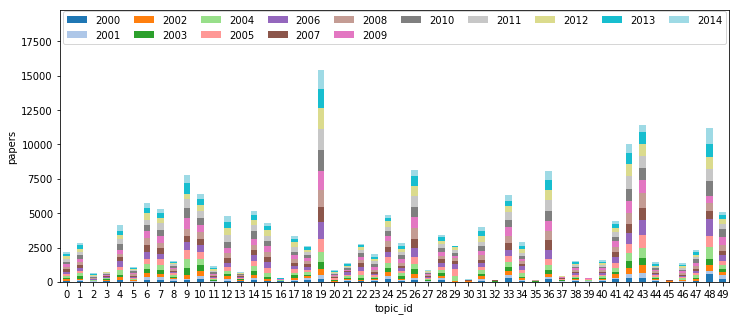

Number of topics concerned in papers published in each year


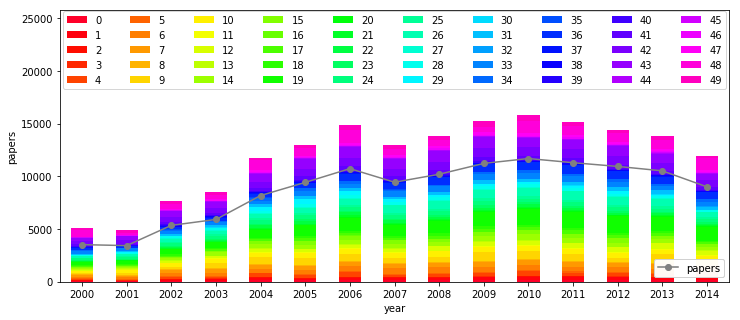

In [4]:
show_all_topics = True
plot_statistics_on_papers(topics_assignments_filename, training_starting_year, diffusion_ending_year, show_all_topics=show_all_topics, output_dir=images_dir)


177486 authors
Number of authors (without repetitions) publishing on a topic by year


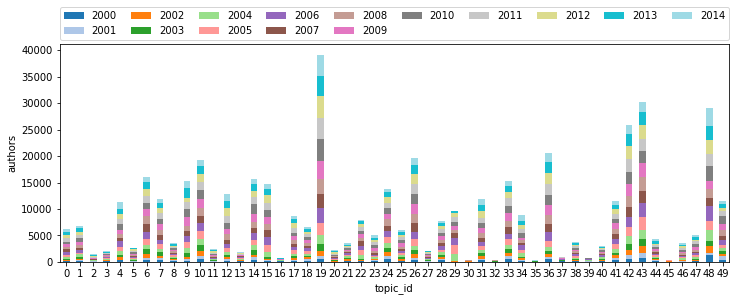

Number of authors (without repetitions) publishing a paper in each year by topic


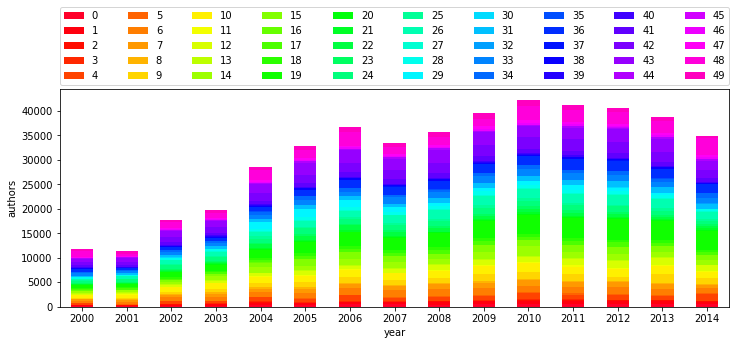

In [5]:
show_all_topics = True
show_repetitions = False
plot_statistics_on_authors(topics_assignments_filename, training_starting_year, diffusion_ending_year, show_all_topics=show_all_topics, show_repetitions=show_repetitions, output_dir=images_dir)


In [6]:
search_for_author("Pens")


                   author  papers
0        Ruggero G. Pensa      15
1   Carolyn Penstein Rosé       6
2  William Russell Pensyl       2
3         Karol A. Penson       1
4         Loris Penserini       1
5         Marianna Pensky       1


Number of papers published in a year by topic


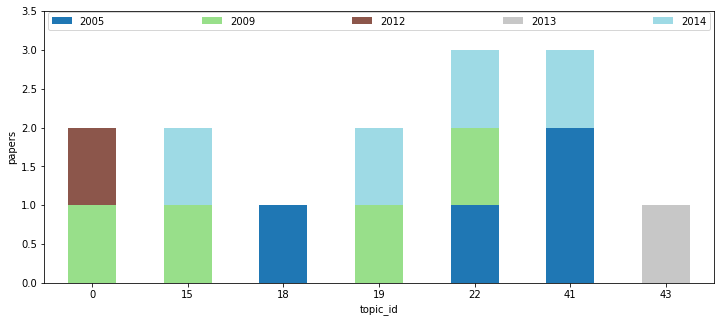

Number of papers concerning a topic by year


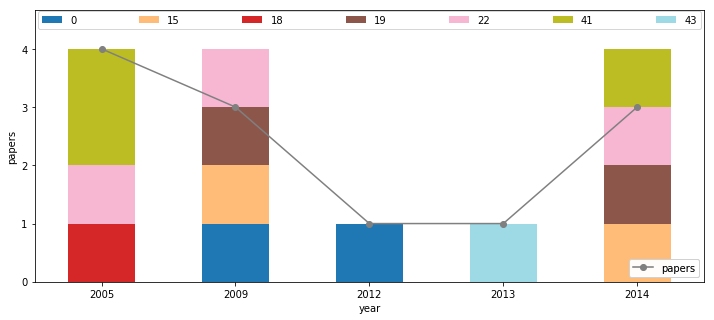

In [7]:
show_all_topics = True
author = "Ruggero G. Pensa" # "Saso Dzeroski" # "Masashi Sugiyama"

plot_author_overview(author, topics_assignments_filename, training_starting_year, diffusion_ending_year, show_all_topics=show_all_topics, output_dir=images_dir)


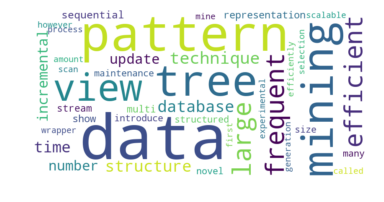

In [8]:
plot_workcloud(41)

## Plot Innovation

In [9]:
########### Diffusion vs. innovation rankings

def plot_diffusion_values(diffusion_filename, topic_id_list, column_diffusion, topics_label_file="", filename=""):
    print("Diffusion")
    csv = pd.read_csv(diffusion_filename)
    if len(topic_id_list) == 1:
        colors = plt.cm.Vega20([0.0])
    else:
        colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    if topics_label_file != "":
        topics_label = pd.read_csv(topics_label_file)
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for topic_id, color, linestyle in zip(topic_id_list, colors, linestyles):
        label="topic "+str(topic_id)
        if topics_label_file != "":
            try:
                label = topics_label[topics_label["topic_id"] == topic_id]["label"].values[0]
            except:
                None#print("topic "+str(topic_id)+" not found")
        plt.plot(csv[csv["topic_id"] == topic_id]["year"], csv[csv["topic_id"] == topic_id][column_diffusion], linestyle, color=color, label=label)
    plt.legend()
    #plot
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

def plot_innovation_file(innovation_filename, topic_id_list, column_innovation, topics_label_file="", filename=""):
    print("Innovation")
    csv = pd.read_csv(innovation_filename)
    if len(topic_id_list) == 1:
        colors = plt.cm.Vega20([0.0])
    else:
        colors = plt.cm.Vega20([x/float(len(topic_id_list)-1) for x in range(len(topic_id_list))])
    if topics_label_file != "":
        topics_label = pd.read_csv(topics_label_file)
    linestyles = ['-', '--', '-.', ':']*round(len(topic_id_list)/4.0 + .5)
    for topic_id, color, linestyle in zip(topic_id_list, colors, linestyles):
        label="topic "+str(topic_id)
        if topics_label_file != "":
            try:
                label = topics_label[topics_label["topic_id"] == topic_id]["label"].values[0]
            except:
                None#print("topic "+str(topic_id)+" not found")
        plt.plot(csv[csv["topic_id"] == topic_id]["time_window_to"], csv[csv["topic_id"] == topic_id][column_innovation], linestyle, color=color, label=label)
    gap_between_xsticks = 1
    plt.xticks(csv[csv["topic_id"] == topic_id]["time_window_to"][::gap_between_xsticks], [str(x)[-2:]+"-"+str(y)[-2:] for x, y in zip(csv[csv["topic_id"] == topic_id]["time_window_from"][::gap_between_xsticks], csv[csv["topic_id"] == topic_id]["time_window_to"][::gap_between_xsticks])])#, rotation=45, horizontalalignment='right')
    plt.legend()
    #plot
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

def plot_innovation_values(delta, gamma, number_of_topics, topic_id_list, column_innovation, innovation_dir, topics_label_file="", filename=""):
    return plot_innovation_file(innovation_dir+"/"+str(delta)+"-"+str(gamma)+"/"+str(number_of_topics)+"-time_windows.csv", topic_id_list, column_innovation, topics_label_file=topics_label_file, filename=filename)

########### Comparison between top values in diffusion and innovation rankings

def get_ranking(filename, ranking_column):
    ranking = pd.read_csv(filename).sort_values(by=ranking_column, ascending=False, inplace=False).reset_index()[["topic_id",ranking_column]]
    ranking["rank"] = ranking.index.values + 1
    return ranking[["topic_id","rank"]]

def get_innovation_rankings(max_delta, number_of_topics, ranking_column, ranking_dir, offset_filename):
    count = 0
    res = [[np.nan for x in range(max_delta+1)] for y in range(max_delta+1)]
    for delta in range(0, max_delta+1):
        for gamma in range(delta+1):
            filename = ranking_dir+"/"+str(delta)+"-"+str(gamma)+"/"+str(number_of_topics)+"-"+offset_filename
            try:
                temp = get_ranking(filename, ranking_column)
                temp.columns = ["topic_id", str(delta)+"-"+str(gamma)]
                if count == 0:
                    res = temp
                else:
                    res = res.merge(temp)
                count += 1
            except:
                None#print("Unexpected error:", sys.exc_info()[0])
    return res

def plot_ranking_topics_ax(ax, csv, topics_list, cmap=plt.cm.Vega20, topics_label_file=""):
    colors = cmap([x/float(len(topics_list)-1) for x in range(len(topics_list))])
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
    if topics_label_file != "":
        topics_label = pd.read_csv(topics_label_file)
    for topic_id, color, marker in zip(topics_list, colors, markers):
        y_values = csv[csv["topic_id"] == topic_id].values[0][1:]
        label="topic "+str(topic_id)
        if topics_label_file != "":
            try:
                label = topics_label[topics_label["topic_id"] == topic_id]["label"].values[0]
            except:
                None#print("topic "+str(topic_id)+" not found")
        ax.plot(range(len(y_values)), y_values, color=color, marker=marker, label=label)
    return

def plot_ranking_topics_points_ax(ax, csv, topics_list, x_value, cmap=plt.cm.Vega20):
    colors = cmap([x/float(len(topics_list)-1) for x in range(len(topics_list))])
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
    for topic_id, color, marker in zip(topics_list, colors, markers):
        y_value = csv[csv["topic_id"] == topic_id].values[0][-1]
        ax.plot(x_value, y_value, "", color=color, marker=marker, label="_topic "+str(topic_id))
    return

def plot_rankings_topics_comparison(topics_list, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename="", filename=""):
    innovation_rankings_csv = get_innovation_rankings(max_delta, number_of_topics, column_innovation, innovation_ranking_dir, innovation_offset_filename)
    diffusion_rankings_csv = get_ranking(diffusion_filename, column_diffusion)
    #plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cmap=plt.cm.Vega20
    plot_ranking_topics_ax(ax, innovation_rankings_csv, topics_list, cmap=cmap, topics_label_file=topics_label_filename)
    plot_ranking_topics_points_ax(ax, diffusion_rankings_csv, topics_list, -1, cmap=cmap)
    plt.legend()
    #first axis
    xticks = ["diff."]
    xticks2_label_positions = [-0.5]
    temp_delta = [-1]
    delta_count = 1
    xticks2_labels = [delta_count]
    for index2, column in enumerate(innovation_rankings_csv.columns[1:]):
        xticks += [column[2:]]
        temp_delta += [int(column[0:1])]
        if delta_count != int(column[0:1]):
            delta_count = int(column[0:1])
            xticks2_label_positions += [index2-0.5]
            xticks2_labels += [delta_count]
    plt.xticks([-1]+[x for x in range(len(innovation_rankings_csv.columns)-1)], xticks)
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel(r"$\gamma$")
    #second axis
    newax = ax.twiny()
    newax.set_frame_on(True)
    newax.patch.set_visible(False)
    newax.xaxis.set_ticks_position('bottom')
    newax.xaxis.set_label_position('bottom')
    newax.spines['bottom'].set_position(('outward', 40))
    # add major ticks
    newax.set_xlim(ax.get_xlim())
    xticks2_label_positions += [newax.get_xlim()[1]]
    newax.set_xticks(xticks2_label_positions)
    newax.set_xticklabels('')
    # add minor ticks
    newax.set_xticks([(x + (y-x)/2.0) for x, y in zip(xticks2_label_positions,xticks2_label_positions[1:])], minor=True)
    newax.set_xticklabels(xticks2_labels, minor=True)
    # hide minor ticks
    for tick in newax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
    newax.set_xlabel(r"$\delta$")
    #plot
    plt.tight_layout()
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

#show the ranking of top range_k topics by innovation
def plot_rankings_comparison(range_k, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename="", filename=""):
    innovation_rankings_csv = get_innovation_rankings(max_delta, number_of_topics, column_innovation, innovation_ranking_dir, innovation_offset_filename)
    #get top topics for diffusion ranking
    if not isinstance(range_k, list):
        range_k = [0, range_k]
    innovation_rankings_csv["mean_rank"] = innovation_rankings_csv[innovation_rankings_csv.columns[1:]].mean(axis=1)
    topics_list = list(innovation_rankings_csv.sort_values(by = "mean_rank", ascending = True)["topic_id"])[range_k[0]:range_k[1]]
    plot_rankings_topics_comparison(topics_list, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename=topics_label_filename, filename=filename)
    return

#show the ranking of top range_k topics by diffusion
def plot_rankings_comparison_2(range_k, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename="", filename=""):
    diffusion_rankings_csv = get_ranking(diffusion_filename, column_diffusion)
    #get top topics for diffusion ranking
    if not isinstance(range_k, list):
        range_k = [0, range_k]
    topics_list = list(diffusion_rankings_csv.sort_values(by = "rank", ascending = True)["topic_id"])[range_k[0]:range_k[1]]
    plot_rankings_topics_comparison(topics_list, max_delta, number_of_topics, column_innovation, column_diffusion, innovation_ranking_dir, innovation_offset_filename, diffusion_filename, topics_label_filename=topics_label_filename, filename=filename)
    return

Diffusion


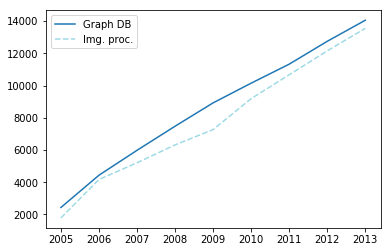

Innovation


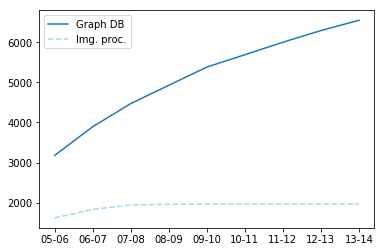

In [10]:
list_of_topics = [43,48]
delta = 2
gamma = 1

plot_diffusion_values(diffusion_dir+"/"+str(number_of_topics)+"-topics.csv", list_of_topics, column_diffusion, topics_label_file=topics_label_filename, filename=images_dir+"/diffusion_sample")
plot_innovation_values(delta, gamma, number_of_topics, list_of_topics, column_innovation, innovation_dir, topics_label_file=topics_label_filename, filename=images_dir+"/innovation_sample")


Top 7 topics by Innovation


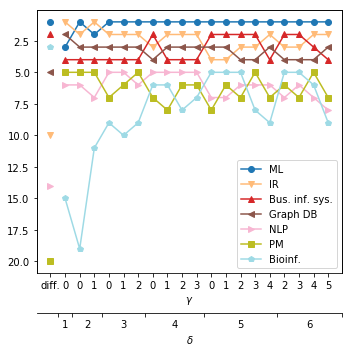

Top 7 topics by Diffusion


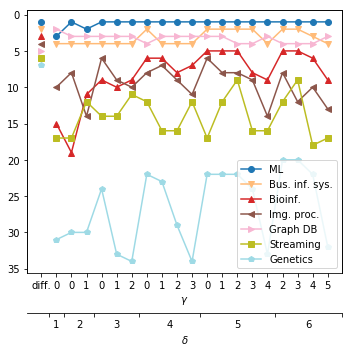

Rank of 5 selected topics


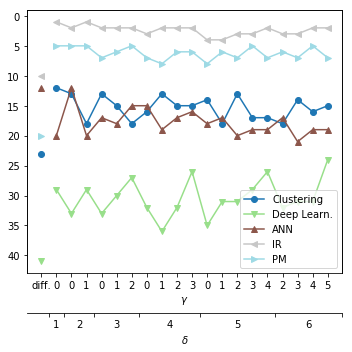

In [11]:
#sns.reset_orig()
list_of_topics = [22,3,33,26,41]
show_top = 7

print("Top", show_top, "topics by Innovation")
plot_rankings_comparison(show_top, max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, "innovation_rank.csv", diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", topics_label_filename=topics_label_filename, filename=images_dir+"/top_rankings_comparison_"+str(number_of_topics))
print("Top", show_top, "topics by Diffusion")
plot_rankings_comparison_2(show_top, max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, "innovation_rank.csv", diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", topics_label_filename=topics_label_filename, filename=images_dir+"/top_rankings_comparison_2_"+str(number_of_topics))
print("Rank of", len(list_of_topics), "selected topics")
plot_rankings_topics_comparison(list_of_topics, max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, "innovation_rank.csv", diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", topics_label_filename=topics_label_filename, filename=images_dir+"/topics_rankings_comparison_"+str(number_of_topics))


## Correlations between delta and gamma

In [12]:
##### Plot correlation between several values of gamma and delta of innovation

def get_correlations(max_delta, number_of_topics, column_innovation, column_diffusion, innovation_dir, diffusion_filename, rank_function):
    result = {}
    res = [[np.nan for x in range(max_delta+1)] for y in range(max_delta+1)]
    diffusion_rank = pd.read_csv(diffusion_filename)
    for delta in range(0, max_delta+1):
        for gamma in range(delta+1):
            try:
                innovation_rank = pd.read_csv(innovation_dir+"/"+str(delta)+"-"+str(gamma)+"/"+str(number_of_topics)+"-innovation_rank.csv")
                innovation_rank = innovation_rank.merge(diffusion_rank, left_on="topic_id", right_on="topic_id", suffixes=["_innovation","_diffusion"])[[column_innovation+"_innovation", column_diffusion+"_diffusion"]]  #(diffusion_rank)[[column_innovation, column_diffusion]]
                corr = rank_function(innovation_rank[column_innovation+"_innovation"].values, innovation_rank[column_diffusion+"_diffusion"].values)
                if rank_function == scipy.stats.pearsonr:
                    res[delta][gamma] = corr[0]
                else:
                    res[delta][gamma] = corr.correlation
            except:
                None#print("Unexpected error:", sys.exc_info()[0])
            gc.collect()
    return res

def plot_heatmap(res, title="", xlabel="", ylabel="", yticklabels=True, xticklabels=True, filename=""):
    mask = np.zeros_like(np.array(res))
    mask[np.where(np.isnan(np.array(res)))] = True
    ax = sns.heatmap(res, mask=mask, annot=True, fmt=".2f", square=1, linewidth=1., cmap=plt.cm.RdBu_r, yticklabels=yticklabels, xticklabels=xticklabels)
    for t in ax.texts:
        t.set_text(t.get_text())
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

def plot_correlations(max_delta, number_of_topics, column_innovation, column_diffusion, innovation_dir, diffusion_filename, rank_function, min_delta=0, min_gamma=0, max_gamma=np.nan, title="", output_dir=""):
    correlations_local = get_correlations(max_delta, number_of_topics, column_innovation, column_diffusion, innovation_dir, diffusion_filename, rank_function)[min_delta:max_delta+1]
    if np.isnan(max_gamma):
        max_gamma = max_delta
    for index in range(len(correlations_local)):
        correlations_local[index] = correlations_local[index][min_gamma:max_gamma]
    if title != "":
        title = title+" "+str(number_of_topics)+" topics"
    if output_dir != "":
        filename = output_dir+"/correlation_inn_diff_"+str(number_of_topics)
    sns.set()
    plot_heatmap(correlations_local, title, r"$\gamma$", r"$\delta$", yticklabels=[x for x in range(min_delta, max_delta+1)], xticklabels=[x for x in range(min_gamma, max_gamma)], filename=filename)
    sns.reset_orig()
    return


##### Plot correlation between several values of gamma of innovation

def plot_correlations_innovation(max_delta, number_of_topics, column_innovation, innovation_dir, rank_function, cmap=plt.cm.summer, filename=""):#, topics_label_filename=""):
    fig = plt.figure(figsize=(13,4))
    ax = fig.add_subplot(111)
    to_plot = []
    xticks_labels = []
    delta_index = []
    old_plot_length = -1
    plot_background = False
    for delta in range(2, max_delta+1):
        for gamma_1 in range(0, delta):
            for gamma_2 in range(gamma_1):
                try:
                    innovation_rank_1 = pd.read_csv(innovation_dir+"/"+str(delta)+"-"+str(gamma_1)+"/"+str(number_of_topics)+"-innovation_rank.csv")
                    innovation_rank_2 = pd.read_csv(innovation_dir+"/"+str(delta)+"-"+str(gamma_2)+"/"+str(number_of_topics)+"-innovation_rank.csv")
                    innovation_rank_1 = innovation_rank_1.merge(innovation_rank_2, left_on="topic_id", right_on="topic_id", suffixes=["_1","_2"])[[column_innovation+"_1", column_innovation+"_2"]]
                    corr = rank_function(innovation_rank_1[column_innovation+"_1"].values, innovation_rank_1[column_innovation+"_2"].values)
                    if rank_function == scipy.stats.pearsonr:
                        to_plot += [corr[0]]
                    else:
                        to_plot += [corr.correlation]
                    xticks_labels += ["("+str(gamma_2)+","+str(gamma_1)+")"]
                    delta_index += [delta]
                except:
                    None#print("Unexpected error:", sys.exc_info()[0])
                gc.collect()
        ax.text(old_plot_length+(len(to_plot) - old_plot_length )/2.0, 1.005, r"$\delta = "+str(delta)+"$",
            verticalalignment='center', horizontalalignment='center',fontsize=11)
        #add background
        if plot_background:
            plt.axvspan(old_plot_length, len(to_plot), color=str(0.9), alpha=0.5)
        plot_background = not(plot_background)
        #add empty space
        if delta != max_delta:
            old_plot_length = len(to_plot)
            to_plot += [0]
            xticks_labels += [""]
            delta_index += [delta]
    if max(delta_index)-min(delta_index) != 0:
        colors = cmap([x/float(max(delta_index)-min(delta_index)) for x in range(max(delta_index)-min(delta_index)+1)])
    else:
        colors = cmap([0.0])

    #plot
    plt.bar(range(len(to_plot)), to_plot, color=[colors[x-min(delta_index)] for x in delta_index])
    plt.xticks(range(len(to_plot)), xticks_labels)
    plt.ylim([0.7, 1.025])
    plt.xlim([-1, len(to_plot)])
    ax.set_xlabel(r'($\gamma_1$,$\gamma_2$)')
    #save
    if filename != "":
        plt.savefig(filename+".eps", format='eps', dpi=1000)
    plt.show()
    plt.close()
    return

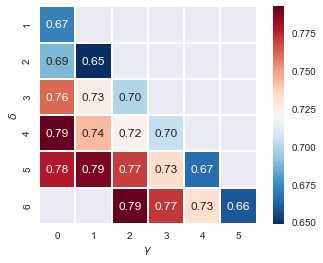

In [13]:
plot_correlations(max_delta, number_of_topics, column_innovation_rank, column_diffusion_rank, innovation_dir, diffusion_dir+"/"+str(number_of_topics)+"-diffusion_rank.csv", scipy.stats.spearmanr, min_delta=1, output_dir=images_dir)


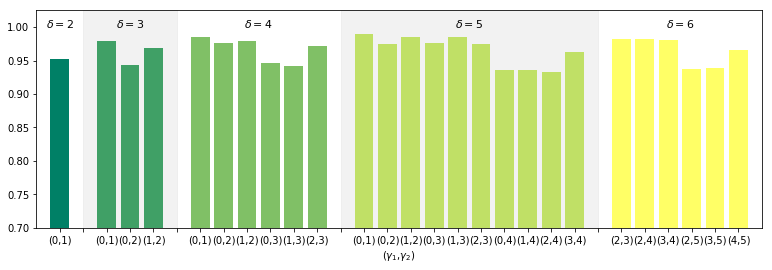

In [14]:
plot_correlations_innovation(max_delta, number_of_topics, column_innovation_rank, innovation_dir, scipy.stats.spearmanr, filename=images_dir+"/correlations_gamma_"+str(number_of_topics))
